### 온열질환자 구간에 따른 Classification 모델 생성
- 1-dimensional
    : binning
- 2-dimensional
    : clustering

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
import os
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense

In [3]:
# 나눔 폰트 경로 설정
# dir = '/data1/E382/hwchoi/00.data/00.preprocessing'
dir='C:/Windows/Fonts'
font_path = os.path.join(dir, 'NANUMGOTHIC.TTF')
# font_path = os.path.join(dir, 'DejaVu Sans')

# 폰트 속성 설정
fontprop = fm.FontProperties(fname=font_path, size=10)


# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)

# Matplotlib 폰트 캐시 파일 삭제 (필요시 사용)
cache_dir = os.path.expanduser('~/.cache/matplotlib')
font_cache_path = os.path.join(cache_dir, 'fontlist-v330.json')
if os.path.exists(font_cache_path):
    os.remove(font_cache_path)

# 폰트를 matplotlib에 설정
plt.rc('font', family=fontprop.get_name())

###  MODELING

### SVM, DecisionTree, RandomForest, XGBoost 데이터 셋 재정리

### 1. Classification / target = max_wbtemp_cluster

In [4]:
path='D:/Work/002.code/jupyterNotebook/data/HEAT_TARGET/T_PATIENTS_DAILY_WHOLE_CLUSTERING_0808.csv'
df=pd.read_csv(path)
df.head(2)

,create_date,sido_cd,sido,weekend_yn,grid_x,grid_y,sat_x,sat_y,min_ta,max_ta,...,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,auto_binning,max_ta_cluster,max_wbtemp_cluster,max_tafeel_cluster,instDate,updtDate
0,2014-05-01,31,경기도,0,60,120,NaN,NaN,9.6,24.2,...,14,21,17,0,0,0,0,0,2024-07-31,2024-07-31
1,2014-05-01,33,충청북도,0,69,107,NaN,NaN,10.5,23.7,...,15,22,18,0,0,0,0,0,2024-07-31,2024-07-31


In [5]:
# create_date에 대한 sorting 적용
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)

In [6]:
features=['weekend_yn', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm', 'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
       'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man', 'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2', 'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target='max_wbtemp_cluster'
print(len(features))

48


In [7]:
# 기본 모델(RandomForest, XGBoost)
# 학습 데이터와 테스트 데이터로 분할
# 데이터 스케일링
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=15, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Label Encoding for y
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.transform(y_test)

In [8]:
def plot_confusion_matrix(conf_matrix, model_name, accuracy):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix\nAccuracy: {accuracy:.2f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [9]:
performance_list = []
num_classes = 4


def evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    confusion = confusion_matrix(y_test, y_pred)
    
    for cls in range(num_classes):
        cls = str(cls)
        performance_list.append({
            'Model': model_name,
            'Class': cls,
            'Accuracy': accuracy,
            'Precision': report[cls]['precision'],
            'Recall': report[cls]['recall'],
            'F1-Score': report[cls]['f1-score'],
            'Support': report[cls]['support']
        })
    
    plot_confusion_matrix(confusion, model_name, accuracy)

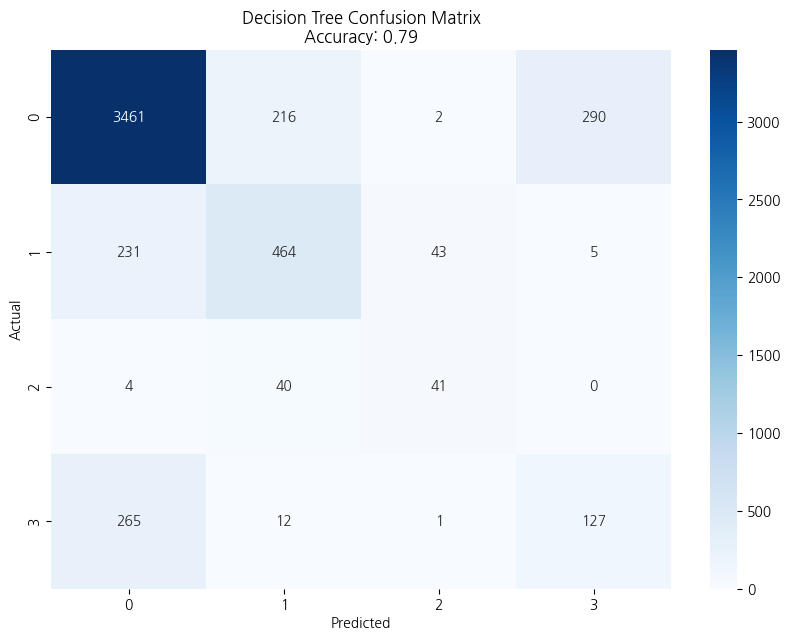

In [10]:
# Decision Tree
dt_classifier = DecisionTreeClassifier(random_state=15)
evaluate_model(dt_classifier, 'Decision Tree')

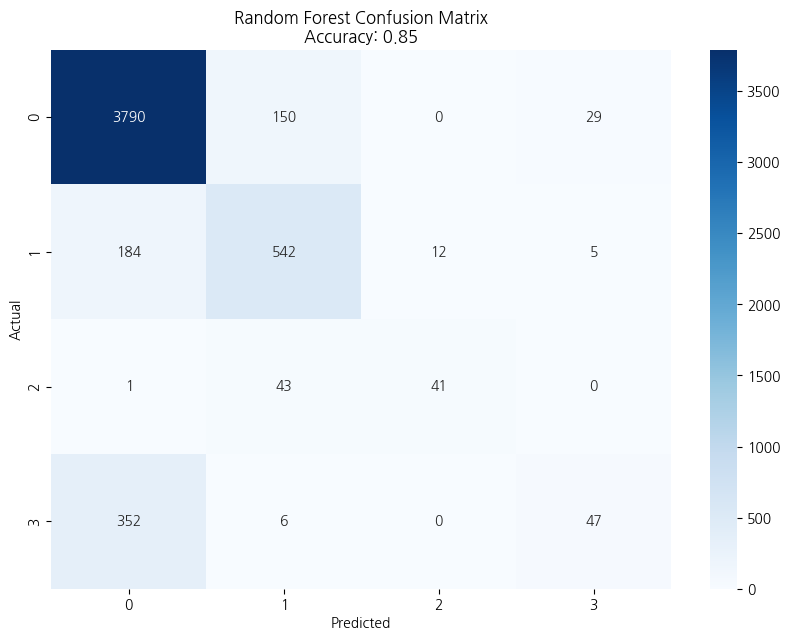

In [11]:
# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=60, random_state=15)
evaluate_model(rf_classifier, 'Random Forest')

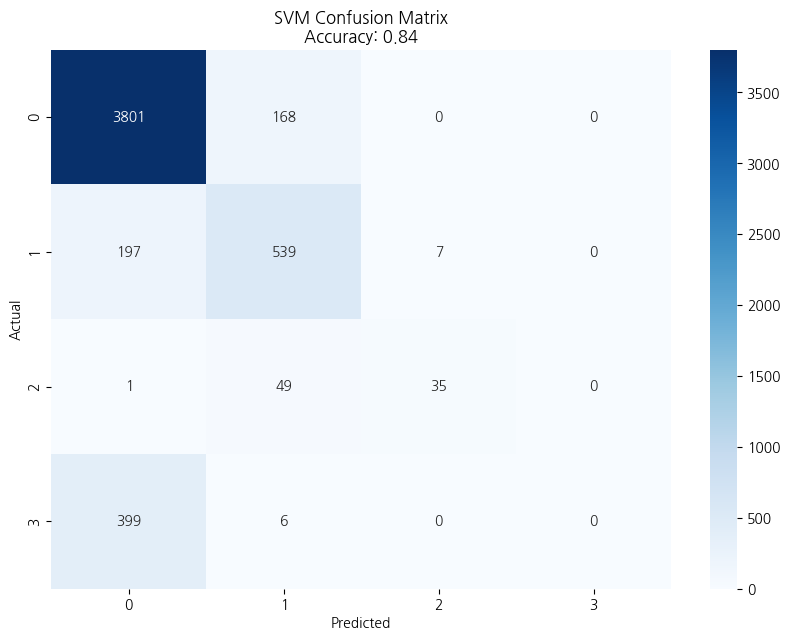

In [12]:
# SVM
svm_classifier = SVC(kernel='linear', random_state=15)
evaluate_model(svm_classifier, 'SVM')

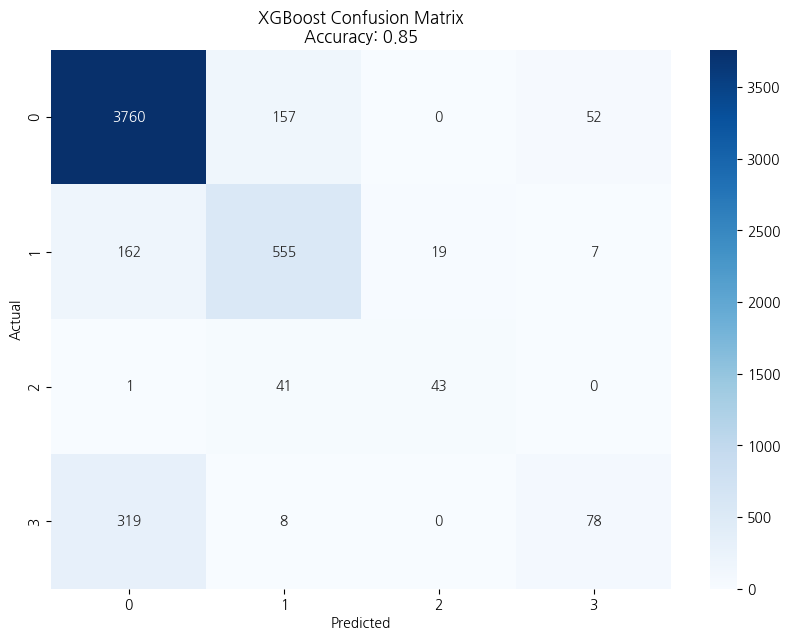

In [13]:
# XGBoost
xgb_classifier = XGBClassifier(eval_metric='logloss', random_state=15)
evaluate_model(xgb_classifier, 'XGBoost')

In [14]:
# 성능 데이터프레임 생성
performance_df = pd.DataFrame(performance_list)
print(performance_df)

            Model Class  Accuracy  Precision    Recall  F1-Score  Support
0   Decision Tree     0  0.786813   0.873769  0.872008  0.872888   3969.0
1   Decision Tree     1  0.786813   0.633880  0.624495  0.629153    743.0
2   Decision Tree     2  0.786813   0.471264  0.482353  0.476744     85.0
3   Decision Tree     3  0.786813   0.300948  0.313580  0.307134    405.0
4   Random Forest     0  0.849673   0.875896  0.954900  0.913693   3969.0
5   Random Forest     1  0.849673   0.731444  0.729475  0.730458    743.0
6   Random Forest     2  0.849673   0.773585  0.482353  0.594203     85.0
7   Random Forest     3  0.849673   0.580247  0.116049  0.193416    405.0
8             SVM     0  0.841023   0.864256  0.957672  0.908569   3969.0
9             SVM     1  0.841023   0.707349  0.725437  0.716279    743.0
10            SVM     2  0.841023   0.833333  0.411765  0.551181     85.0
11            SVM     3  0.841023   1.000000  0.000000  0.000000    405.0
12        XGBoost     0  0.852749   0.

In [15]:
performance_df.to_csv('performance_max_wbtemp_cluster.csv', index=False, encoding='utf-8-sig')